In [1]:
import pickle
import numpy as np
from rve_utils2 import get_trainer, get_engine_runs, plot_engine_run
from collections import defaultdict
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

In [5]:
print(f"CUDA vesion: {torch.version.cuda}")
print(f"Pytorch version: {torch.__version__}")

CUDA vesion: 11.2
Pytorch version: 1.13.1.post200


In [54]:
class MultiplicativeAttention(nn.Module):

    def __init__(self, values_embedding, queries_embedding):
        super().__init__()
        self.values_embedding = values_embedding
        self.queries_embedding = queries_embedding
        self.W = torch.nn.Parameter(torch.FloatTensor(
            self.queries_embedding, self.values_embedding).uniform_(-0.1, 0.1), requires_grad=True)

    def forward(self,
        query,  # [Batch size, N queries, queries_dim]
        values # [Batch size, N values, values_dim]
    ):

        weights = query @ self.W.unsqueeze(0) @ values.permute(0, -1, -2)  # [Batch size, N queries, N values]
        weights /= np.sqrt(self.queries_embedding)
        out = weights @ values # [Batch size, N queries, values_dim]
        return out  

In [55]:
Q = torch.rand((1,10, 7))
V = torch.rand((1, 30, 5))
W = torch.rand((5,5))

print(W.shape, V.shape)

att = MultiplicativeAttention(5,7)

print(att(Q, V).shape)
att(Q, V)

torch.Size([5, 5]) torch.Size([1, 30, 5])


TypeError: permute(): argument 'dims' (position 1) must be tuple of ints, not ellipsis

In [5]:
dataset_name = "FD004"

with open(f"./data_rve/{dataset_name}_x_train.dump", "rb") as input_file:
    x_train = pickle.load(input_file)
with open(f"./data_rve/{dataset_name}_y_train.dump", "rb") as input_file:
    y_train = pickle.load(input_file)

with open(f"./data_rve/{dataset_name}_x_val.dump", "rb") as input_file:
    x_val = pickle.load(input_file)
with open(f"./data_rve/{dataset_name}_y_val.dump", "rb") as input_file:
    y_val = pickle.load(input_file)
    
with open(f"./data_rve/{dataset_name}_x_test.dump", "rb") as input_file:
    x_test = pickle.load(input_file)
with open(f"./data_rve/{dataset_name}_y_test.dump", "rb") as input_file:
    y_test = pickle.load(input_file)

In [6]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(43523, 30, 6)
(10505, 30, 6)
(248, 30, 6)


In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class simpledataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    def __len__(self):
        return len(self.targets)
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

train_data = simpledataset(x_train, y_train)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
x = next(iter(train_loader))
print(x[0].shape, x[1].shape)

torch.Size([128, 30, 6]) torch.Size([128, 1])


In [8]:
x_test[x_test == -99] = 0
x_test.min()

-2.5449789

In [857]:
np.arange(-0.2,2,10)

array([-0.2])

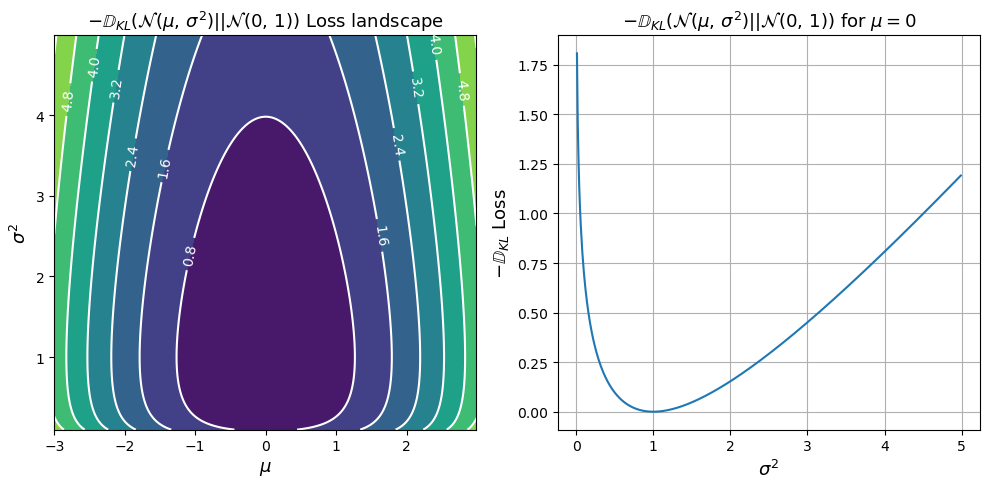

In [893]:
def Dkl_loss(mean, var):
    return -0.5 * (1 + np.log(var) - mean ** 2 - var)

def Dkl_loss2(mean, var, prior_mean, prior_var):
    return -0.5 * (1 + np.log(var) - mean ** 2 - var)

def plot_decision_surface(xmin, xmax, ymin, ymax, func, save=True, title="D_kl_loss_landscape"):
    x = np.arange(xmin, xmax, 0.01)
    y = np.arange(ymin, ymax, 0.01)
    
    xv, yv = np.meshgrid(x, y)
    x = xv.ravel()
    y = yv.ravel()
    c = Dkl_loss(x, y)
    c = c.reshape(xv.shape)
    
    mean = 0
    var = np.arange(0.01, 5, 0.01)
    l = Dkl_loss(mean, var)
    
    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    ax[0].contourf(xv, yv, c)
    plt1 = ax[0].contour(xv, yv, c, colors='w')
    ax[0].clabel(plt1, fontsize=10, inline=True)
    
    ax[1].plot(var, l)
    ax[1].grid(True)
    
    ax[0].set_title("$-\mathbb{D}_{KL} (\mathcal{N}(\mu,\,\sigma^{2}) || \mathcal{N}(0,\,1))$ Loss landscape", fontsize=13)
    ax[0].set_xlabel("$\mu$", fontsize=13)
    ax[0].set_ylabel("$\sigma^{2}$", fontsize=13)
    ax[1].set_title("$-\mathbb{D}_{KL} (\mathcal{N}(\mu,\,\sigma^{2}) || \mathcal{N}(0,\,1))$ for $\mu=0$", fontsize=13)
    ax[1].set_xlabel("$\sigma^{2}$", fontsize=13)
    ax[1].set_ylabel("$-\mathbb{D}_{KL}$ Loss", fontsize=13)
    plt.tight_layout()
    
    if save:
        plt.savefig("./images/"+str(title)+".png")

plot_decision_surface(-3, 3, 0.1, 5, Dkl_loss)

In [839]:
Dkl_loss(0, 0.01)

1.8075850929940454

In [2]:
import pickle
import numpy as np
from rve_utils2 import get_trainer, get_engine_runs, plot_engine_run
from collections import defaultdict
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

In [9]:
class SimpleRVE(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=False, dropout=0, num_layers=1):
        super(SimpleRVE, self).__init__()
        self.decode_mode = False
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.p = dropout
        self.num_layers = num_layers
        if self.bidirectional:
            self.D = 2
        else:
            self.D = 1
            
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.mu = nn.Linear(in_features=self.D*hidden_size, out_features=2)
        self.sigma = nn.Linear(in_features=self.D*hidden_size, out_features=2)
        
        self.regressor = nn.Sequential(nn.Linear(2, 200), nn.Tanh(), nn.Dropout(self.p), nn.Linear(200, 1))
    
    def forward(self, x):
        batch = x.shape[0]
        _, (hn, _) = self.lstm(x)
        """
        hidden.shape = (num_layers*num_directions, batch, hidden_size)
        layers can be separated using h_n.view(num_layers, num_directions, batch, hidden_size)
        So you shouldn’t simply do hidden[-1] but first do a view() to separate the num_layers and num_directions (1 or 2). If you do

        hidden = hidden.view(num_layers, 2, batch, hidden_size) # 2 for bidirectional
        last_hidden = hidden[-1]
        then last_hidden.shape = (2, batch, hidden_size) and you can do

        last_hidden_fwd = last_hidden[0]
        last_hidden_bwd = last_hidden[1]
        """
       
        hn = hn.view(self.num_layers, self.D, batch, self.hidden_size)
        
        last_hidden = hn[-1]
        if self.bidirectional:
            out = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
        else:
            out = last_hidden[0]
        
        
        mu = self.mu(out)
        sigma = self.sigma(out)
        
        eps = torch.randn_like(sigma)
        z = mu + eps*torch.exp(0.5*sigma)
     
        
        y_hat = self.regressor(z)
     
        return y_hat, z, mu, sigma
        
        
def viz_latent_space(model, data, targets=[], title="Final", save=False, show=True):
    data = torch.tensor(data).float()
    model.to("cpu")
    with torch.no_grad():
        _,z, *_ = model(data)
        z = z.numpy()
    plt.figure(figsize=(8, 4))
    if len(targets)>0:
        plt.scatter(z[:, 0], z[:, 1], c=targets, s=1.5)
    else:
        plt.scatter(z[:, 0], z[:, 1])
    plt.xlabel("z - dim 1")
    plt.ylabel("z - dim 2")
    plt.colorbar()
    plt.title(title)
    if show:
        plt.tight_layout()
    if save:
        plt.savefig("./images/latent_space_" + str(title) + ".png")       

In [10]:
import seaborn as sns
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_engine_runs(dataloader, model):
    engine_ids = dataloader.dataset.ids
    history = defaultdict(dict)
    model.eval().to("cpu")

    for engine_id in engine_ids:
        with torch.no_grad():
            x, y = dataloader.dataset.get_run(engine_id)
            y_hat, z, *_ = model(x)
            history[engine_id]["rul"] = y.numpy()
            history[engine_id]["rul_hat"] = y_hat.numpy()
            history[engine_id]["z"] = z.numpy()

    return history


def viz_latent_space_noise(model, dataloader, engine_id=None, mean=0, std=1, n_runs=6, title="FD003_noise", save=True, show=True):
    
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    device = "cpu"
    
    engine_ids = dataloader.dataset.ids
    if engine_id is None:
        engine_id = random.choice(list(engine_ids))
        
     
    #Get latent space without noise:
    z_space = []
    targets = []

    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            y_hat, z, *_ = model(x)
            z_space.append(z.detach().cpu().numpy())
            targets.append(y.detach().cpu().numpy())
    z_space = np.concatenate(z_space)
    targets = np.concatenate(targets)
    targets = np.squeeze(targets)
    
    # Z-space with noise:
    z_space_noise = []
    z_space_noise_y = []
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            x += torch.empty_like(x).normal_(mean=mean,std=std)
            y_hat, z, *_ = model(x)
            z_space_noise.append(z.detach().cpu().numpy()) 
            z_space_noise_y.append(y.detach().cpu().numpy()) 
    z_space_noise = np.concatenate(z_space_noise)
    z_space_noise_y = np.concatenate(z_space_noise_y)
    z_space_noise_y = np.squeeze(z_space_noise_y)

    #Get engine runs with noise:
    engine_z = []
    engine_y_hat = []
    engine_y_true = []
    
    with torch.no_grad():
        x, y = dataloader.dataset.get_run(engine_id)
        x, y = x.to(device), y.to(device)
        y_hat, z, *_ = model(x)
    engine_z_nonoise = z.detach().cpu().numpy()
    engine_y_nonoise = y.detach().cpu().numpy()

    for run in range(n_runs):
        with torch.no_grad():
            x, y = dataloader.dataset.get_run(engine_id)
            x, y = x.to(device), y.to(device)
            x += torch.empty_like(x).normal_(mean=mean,std=std)
            y_hat, z, *_ = model(x)
            engine_z.append(z.detach().cpu().numpy())
            engine_y_true.append(y.detach().cpu().numpy())
    engine_z = np.concatenate(engine_z)
    engine_y_true = np.concatenate(engine_y_true)
    engine_y_true = np.squeeze(engine_y_true)
    engine_y_true = np.squeeze(engine_y_true)
    
    
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 10))
    targets = np.squeeze(targets)
    
   
    pc = ax[0][0].scatter(z_space[:, 0], z_space[:, 1], c=targets, s=5, alpha=1)
    divider = make_axes_locatable(ax[0][0])
    ccx = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(pc, cax=ccx)
    ax[0][0].set_title("Latent Space w/o noise")
    ax[0][0].set_xlabel("z - dim 1")
    ax[0][0].set_ylabel("z - dim 2")
    
    pd = ax[1][0].scatter(z_space_noise[:, 0], z_space_noise[:, 1], c=z_space_noise_y, s=5, alpha=1)
    divider = make_axes_locatable(ax[1][0])
    cdx = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(pd, cax=cdx)
    ax[1][0].set_title(f"Latent Space with noise $\mu$={mean} $\sigma$={std}")
    ax[1][0].set_xlabel("z - dim 1")
    ax[1][0].set_ylabel("z - dim 2")
    
    pa = ax[0][1].scatter(z_space[:, 0], z_space[:, 1], c=targets, s=5, alpha=1)
    pf=ax[0][1].scatter(engine_z[:, 0], engine_z[:, 1],c=engine_y_true, s=5, alpha=1, cmap=plt.cm.gist_heat_r)
    divider = make_axes_locatable(ax[0][1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cfx = divider.append_axes("right", size="5%", pad=0.6)
    plt.colorbar(pf, cax=cfx)
    plt.colorbar(pa, cax=cax)
    ax[0][1].set_title(f"{n_runs} trajectories of Engine Unit #{engine_id} with noise.")
    ax[0][1].set_xlabel("z - dim 1")
    ax[0][1].set_ylabel("z - dim 2")

    
    engine_y_true = np.squeeze(engine_y_true)
    #"YlGnBu_r" "YlOrBr_r"
    divider = make_axes_locatable(ax[1][1])
    cbx = divider.append_axes("right", size="5%", pad=0.05)
    cbbx = divider.append_axes("right", size="5%", pad=0.6)
    #sns.kdeplot(x=engine_z[:, 0], y=engine_z[:, 1], ax=ax[1][1], cmap="Reds",  fill=True, thresh=0.01, alpha=1.0, cbar=True, cbar_ax = cbx, cut=1)
    pb = ax[1][1].scatter(z_space[:, 0], z_space[:, 1], c=targets, s=5, alpha=1)
    sns.kdeplot(x=engine_z[:, 0], y=engine_z[:, 1], ax=ax[1][1], cmap="coolwarm", fill=True, thresh=0.02, alpha=0.7, cbar=True, cbar_ax = cbbx, cut=3)
    plt.colorbar(pb, cax=cbx)
    ax[1][1].scatter(engine_z_nonoise[:, 0], engine_z_nonoise[:, 1], c=engine_y_nonoise, s=6, cmap=plt.cm.gist_heat_r, alpha=1)
    ax[1][1].set_title(f"PDF of {n_runs} trajectories of Engine Unit #{engine_id} with noise.")
    ax[1][1].set_xlabel("z - dim 1")
    ax[1][1].set_ylabel("z - dim 2")    
    
    if show:
        plt.tight_layout()
    if save:
        plt.savefig("./images/" + str(title) + f"_std_{std}" + f"_eng_{engine_id}" + ".png")
    plt.show()


In [14]:

import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from rve_utils2 import get_trainer, get_engine_runs, plot_engine_run
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=False, dropout=0, num_layers=1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.p = dropout
        self.num_layers = num_layers
        if self.bidirectional:
            self.D = 2
        else:
            self.D = 1
            
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.mu = nn.Linear(in_features=self.D*hidden_size, out_features=2)
        self.log_var = nn.Linear(in_features=self.D*hidden_size, out_features=2)
        
        self.regressor = nn.Sequential(nn.Linear(2, 200), nn.Tanh(), nn.Dropout(self.p), nn.Linear(200, 1))
    
    def forward(self, x):
        batch = x.shape[0]
        _, (hn, _) = self.lstm(x)
        """
        hidden.shape = (num_layers*num_directions, batch, hidden_size)
        layers can be separated using h_n.view(num_layers, num_directions, batch, hidden_size)
        So you shouldn’t simply do hidden[-1] but first do a view() to separate the num_layers and num_directions (1 or 2). If you do

        hidden = hidden.view(num_layers, 2, batch, hidden_size) # 2 for bidirectional
        last_hidden = hidden[-1]
        then last_hidden.shape = (2, batch, hidden_size) and you can do

        last_hidden_fwd = last_hidden[0]
        last_hidden_bwd = last_hidden[1]
        """
       
        hn = hn.view(self.num_layers, self.D, batch, self.hidden_size)
        
        last_hidden = hn[-1]
        if self.bidirectional:
            out = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
        else:
            out = last_hidden[0]
        
        mu = self.mu(out)
        log_var = self.log_var(out)
        
        eps = torch.randn_like(log_var)
        z = mu + eps*torch.exp(0.5*log_var)
        
     
        return z, mu, log_var


class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, time_steps=30, bidirectional=False, dropout=0, num_layers=1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.p = dropout
        self.num_layers = num_layers
        self.time_steps = time_steps
        if self.bidirectional:
            self.D = 2
        else:
            self.D = 1
        self.lstm = nn.LSTM(input_size=2, hidden_size=self.D*hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Sequential(nn.Dropout(self.p), nn.Linear(in_features=self.D*hidden_size, out_features=input_size))
        
    def forward(self, z):
        x_hat = z.unsqueeze(1).repeat(1, self.time_steps, 1)
        x_hat, _ = self.lstm(x_hat)
        x_hat = self.fc(x_hat)
        return x_hat
    
    
class ERVE(nn.Module):
    
    @staticmethod
    def score(y, y_hat):
        score = 0
        y = y.cpu()
        y_hat = y_hat.cpu()
        for i in range(len(y_hat)):
            if y[i] <= y_hat[i]:
                score += np.exp(-(y[i] - y_hat[i]) / 10.0) - 1
            else:
                score += np.exp((y[i] - y_hat[i]) / 13.0) - 1
        return score

    @staticmethod
    def dkl_loss(mean, log_var):
        loss = (-0.5 * (1 + log_var - mean ** 2 - torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        return loss

    @staticmethod
    def regression_loss(y, y_hat):
        criterion = nn.MSELoss()
        return  criterion(y, y_hat)

    @staticmethod
    def reconstruction_loss(x, x_hat):
        batch_size = x.shape[0]
   
        criterion = nn.MSELoss(reduction='none')
        loss = criterion(x, x_hat)
        loss = loss.view(batch_size, -1).sum(axis=1)
        loss = loss.mean()
        return loss
    
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 bidirectional=False, 
                 dropout=0, 
                 num_layers=1,
                 reg_fc_dim=200,
                 decode_mode = True,
                 reg_loss = True,
                 kl_loss=True, 
                 recon_loss=False,  
                 custom_kl_loss=None, 
                 custom_reg_loss=None, 
                 custom_recon_loss=None
                ):
        super(ERVE, self).__init__()
        self.decode_mode = decode_mode
        if self.decode_mode:
            if recon_loss == False:
                recon_loss = True
                print(f"decon_mode overrides recon_loss to: {recon_loss}")
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.p = dropout
        
        self.num_layers = num_layers
        self.reg_loss = reg_loss
        self.kl_loss = kl_loss
        self.rec_loss = recon_loss
        if custom_reg_loss is not None:
            self.reg_loss_criterion = custom_reg_loss
        else:
            self.reg_loss_criterion = ERVE.regression_loss
        if custom_kl_loss is not None:
            self.kl_loss_criterion = custom_kl_loss
        else:
            self.kl_loss_criterion = ERVE.dkl_loss
        if custom_recon_loss is not None:
            self.recon_loss_criterion = custom_recon_loss
        else:
            self.recon_loss_criterion = ERVE.reconstruction_loss
            
        self.encoder = Encoder(input_size, hidden_size, bidirectional=False, dropout=dropout, num_layers=1)
        self.decoder = Decoder(input_size, hidden_size, time_steps=30, bidirectional=False, dropout=dropout, num_layers=1)
        self.regressor = nn.Sequential(nn.Linear(2, reg_fc_dim), nn.Tanh(), nn.Dropout(self.p), nn.Linear(reg_fc_dim, 1))
    
    def forward(self, x):
        batch = x.shape[0]
        losses = dict()
        
        z, mu, log_var = self.encoder(x)
        y_hat = self.regressor(z)
        if self.decode_mode:
            x_hat = self.decoder(z)
            return y_hat, z, mu, log_var, x_hat 
          
        return y_hat, z, mu, log_var

In [7]:

model = torch.load('./saved_models/FD003_dkl_recon_reg.pt')
model.eval()

ERVE(
  (encoder): Encoder(
    (lstm): LSTM(5, 150, batch_first=True)
    (mu): Linear(in_features=150, out_features=2, bias=True)
    (log_var): Linear(in_features=150, out_features=2, bias=True)
    (regressor): Sequential(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.7, inplace=False)
      (3): Linear(in_features=200, out_features=1, bias=True)
    )
  )
  (decoder): Decoder(
    (lstm): LSTM(2, 150, batch_first=True)
    (fc): Sequential(
      (0): Dropout(p=0.7, inplace=False)
      (1): Linear(in_features=150, out_features=5, bias=True)
    )
  )
  (regressor): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [8]:
def get_z_space(model, dataloader,  save=False, show=True):
    
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    device = "cpu"
        
    #Get latent space without noise:
    z_space = []
    targets = []

    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            y_hat, z, *_ = model(x)
            z_space.append(z.detach().cpu().numpy())
            targets.append(y.detach().cpu().numpy())
    z_space = np.concatenate(z_space)
    targets = np.concatenate(targets)
    targets = np.squeeze(targets)
    return z_space, targets

In [129]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def cluster(z, y, n_clusters=20):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    clusters = kmeans.fit_predict(z)

    centroids = kmeans.cluster_centers_
    """vor = Voronoi(centroids)
    voronoi_plot_2d(vor)"""


    means = np.zeros_like(clusters)
    vars = np.zeros_like(clusters)
    cluster_sizes = np.zeros_like(clusters)
    density =  np.zeros(n_clusters)
    cluster_size_short = np.zeros(n_clusters)
    vars_short = np.zeros(n_clusters)
    for i in range(n_clusters):
        mask = (clusters==i)
        cluster_targets = y[mask]
        z_points = z[mask]
        means[mask] = np.mean(cluster_targets)
        vars[mask] = np.var(cluster_targets)
        cluster_sizes[mask] = cluster_targets.shape[0]

        cluster_size_short[i] = cluster_targets.shape[0]
        vars_short[i] = np.var(cluster_targets)

        density[i] = np.sum(np.linalg.norm(z_points-centroids[i], ord=2, axis=1)/cluster_targets.shape[0])
        #print(f"cluster: {i} mean: {np.unique(means[mask]).item()} var: {np.unique(vars[mask]).item()} size: {np.unique(cluster_sizes[mask]).item()} dist: {density[i].item()}")

    metric = np.sum(cluster_size_short*vars_short)/np.sum(cluster_size_short)
    print("metric", np.round(metric,5)) 


    fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15, 5))
    
    pa = ax[0].scatter(z[:, 0], z[:, 1], c=clusters, s=5, alpha=1, cmap="tab20")
    divider = make_axes_locatable(ax[0])
    ccx = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(pa, cax=ccx)
    ax[0].set_title("Latent Space w/o noise")
    ax[0].set_xlabel("z - dim 1")
    ax[0].set_ylabel("z - dim 2")

    pc = ax[1].scatter(z[:, 0], z[:, 1], c=y, s=2, alpha=1)
    divider = make_axes_locatable(ax[1])
    ccx = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(pc, cax=ccx)
    ax[1].set_title("Latent Space w/o noise")
    ax[1].set_xlabel("z - dim 1")
    ax[1].set_ylabel("z - dim 2")

    pb = ax[2].scatter(z[:, 0], z[:, 1], c=vars, s=5, alpha=1, cmap="Reds")
    divider = make_axes_locatable(ax[2])
    ccx = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(pb, cax=ccx)
    ax[2].set_title("Latent Space w/o noise")
    ax[2].set_xlabel("z - dim 1")
    ax[2].set_ylabel("z - dim 2")

    plt.tight_layout()
    pass

In [84]:
sensors = ['s_3', 's_4', 's_7', 's_11', 's_12'] #FD001 FD003
#sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD004
#sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD002
#sensors = [f's_{i}' for i in range(1,22)]

input_size = len(sensors)
hidden_dim = 150


trainer, x_train, y_train, x_val, y_val, x_test, y_test, train_loader, test_loader, val_loader = get_trainer("FD003", sensors, reconstruct=True, model=model, lr=0.001, alpha=1)


z, y = get_z_space(model, val_loader,  save=False, show=True)
print(z.shape, y.shape)

(3784, 2) (3784,)


metric 218.4882


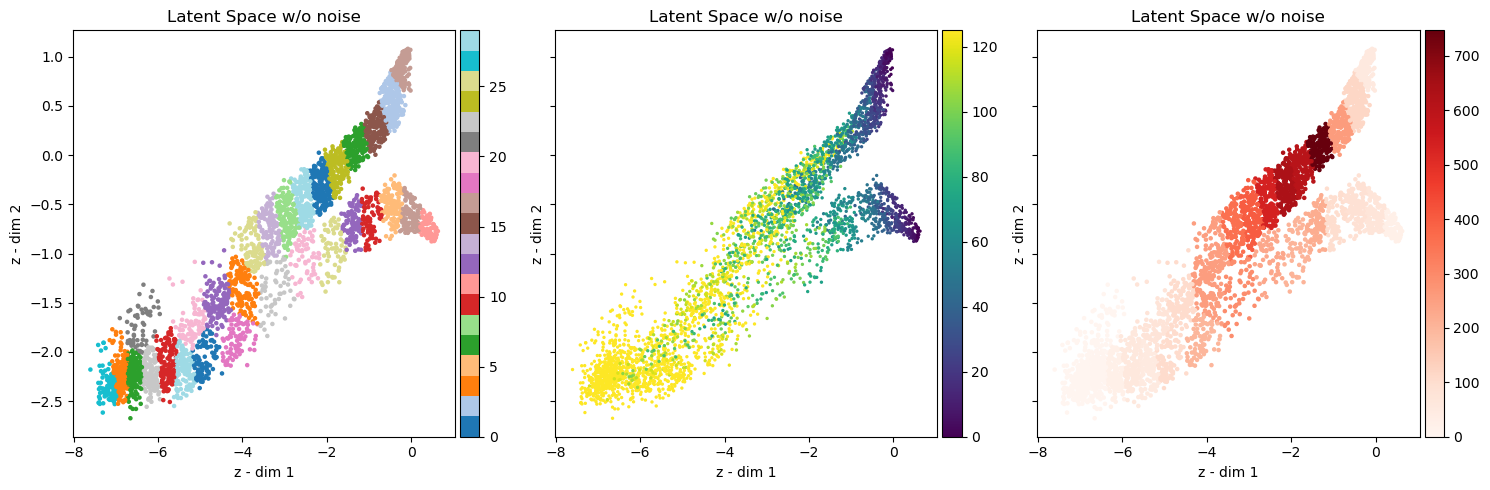

In [133]:
cluster(z, y, n_clusters=30)

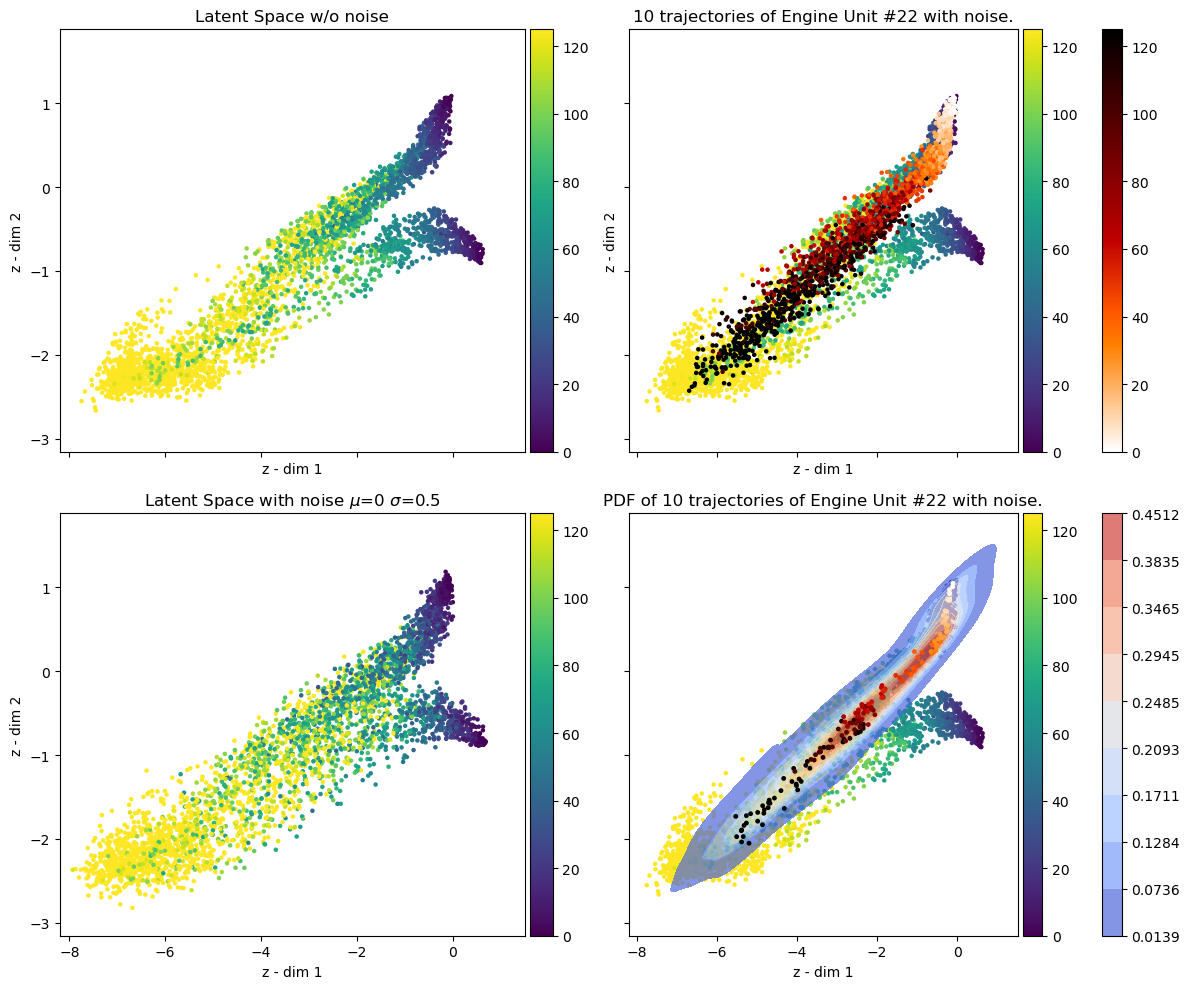

In [16]:
sensors = ['s_3', 's_4', 's_7', 's_11', 's_12'] #FD001 FD003
#sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD004
#sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD002
#sensors = [f's_{i}' for i in range(1,22)]

input_size = len(sensors)
hidden_dim = 150


trainer, x_train, y_train, x_val, y_val, x_test, y_test, train_loader, test_loader, val_loader = get_trainer("FD003", sensors, reconstruct=True, model=model, lr=0.001, alpha=1)


viz_latent_space_noise(model, val_loader, n_runs=10, std=0.5, title="FD004_noise")

In [133]:
import pandas as pd
index_names = ['Engine ID', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i + 1) for i in range(0, 21)]
sensors = ['s_7','s_12']
col_names = index_names + setting_names + sensor_names
# remove unused sensors
drop_sensors = [element for element in sensor_names if element not in sensors]

train_file = './CMAPSSData/train_FD003.txt'

# data readout
train = pd.read_csv(train_file, sep=r'\s+', header=None,names=col_names)
train.drop(drop_sensors,axis=1, inplace=True)
df = train[train["Engine ID"].isin([30, 33,73, 31, 76, 45, 12])]
dff = df.copy()
#dff[sensors] = df[sensors].apply(lambda x: (x-x.mean())/x.std())

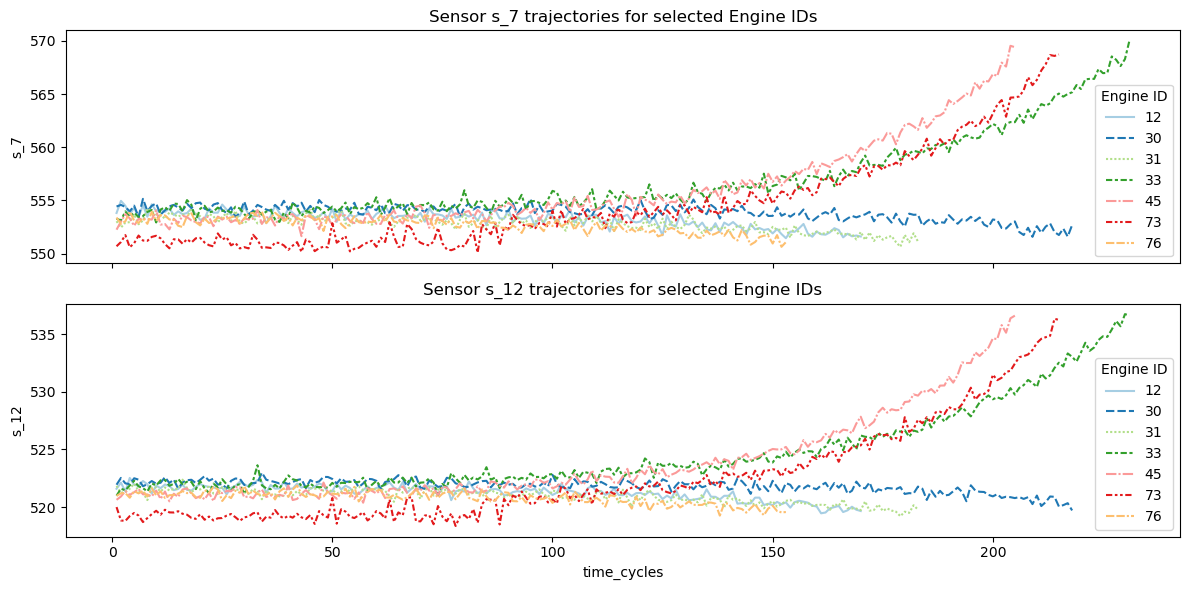

In [142]:
import seaborn as sns

fig , ax = plt.subplots(2,1, sharex=True, figsize=(12,6))
for i, sensor in enumerate(sensors):
    sns.lineplot(
        data=dff,
        x="time_cycles", y=sensor,
        hue="Engine ID",ax=ax[i], style="Engine ID", palette="Paired"
    ).set_title(f'Sensor {sensor} trajectories for selected Engine IDs')
plt.tight_layout()
plt.savefig(f"./images/sensor_plots_for_FD003_sensors.png")


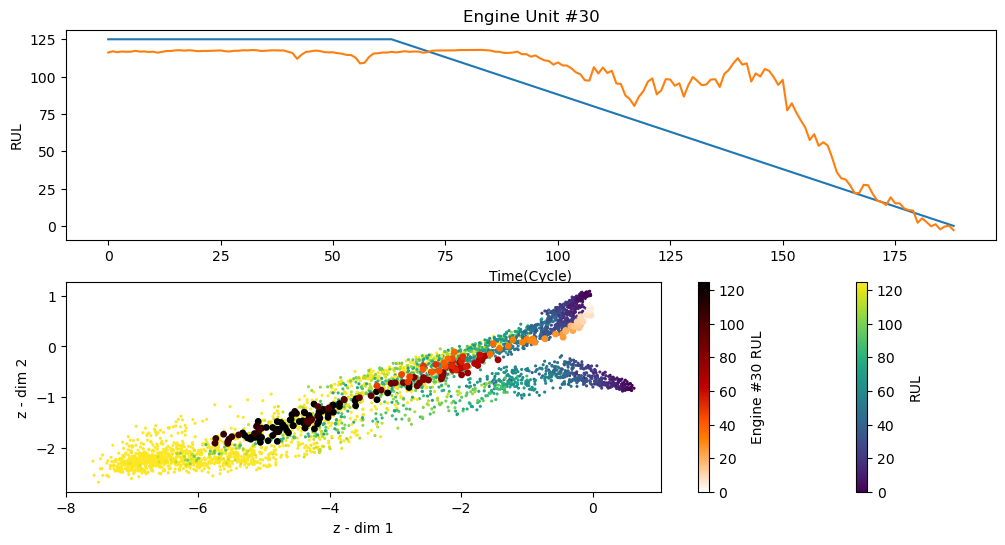

In [114]:
history = get_engine_runs(val_loader, model)
plot_engine_run(history, 30, save=True, title="FD003_all_losses")

In [458]:
torch.empty(5).normal_(mean=4,std=0.5)

tensor([4.6120, 4.8561, 4.8303, 3.8990, 4.1527])

In [456]:
batches = [torch.rand(3,2,2).numpy() for _ in range(2)]

out = np.concatenate(batches)
print(out.shape)

(6, 2, 2)


$$\mathcal{L}_{RVE} = \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}[log \; p_{\theta} (\mathbf{x}|\mathbf{z})] - \mathbb{D}_{KL} (q_{\phi}(\mathbf{z}|\mathbf{x})||p_{\theta}(\mathbf{z})) + \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}[log \; d_{\gamma} (\mathbf{y}|\mathbf{z})]$$

In [1]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=False, dropout=0, num_layers=1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.p = dropout
        self.num_layers = num_layers
        if self.bidirectional:
            self.D = 2
        else:
            self.D = 1
            
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.mu = nn.Linear(in_features=self.D*hidden_size, out_features=2)
        self.log_var = nn.Linear(in_features=self.D*hidden_size, out_features=2)
        
        self.regressor = nn.Sequential(nn.Linear(2, 200), nn.Tanh(), nn.Dropout(self.p), nn.Linear(200, 1))
    
    def forward(self, x):
        batch = x.shape[0]
        _, (hn, _) = self.lstm(x)
        """
        hidden.shape = (num_layers*num_directions, batch, hidden_size)
        layers can be separated using h_n.view(num_layers, num_directions, batch, hidden_size)
        So you shouldn’t simply do hidden[-1] but first do a view() to separate the num_layers and num_directions (1 or 2). If you do

        hidden = hidden.view(num_layers, 2, batch, hidden_size) # 2 for bidirectional
        last_hidden = hidden[-1]
        then last_hidden.shape = (2, batch, hidden_size) and you can do

        last_hidden_fwd = last_hidden[0]
        last_hidden_bwd = last_hidden[1]
        """
       
        hn = hn.view(self.num_layers, self.D, batch, self.hidden_size)
        
        last_hidden = hn[-1]
        if self.bidirectional:
            out = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
        else:
            out = last_hidden[0]
        
        mu = self.mu(out)
        log_var = self.log_var(out)
        
        eps = torch.randn_like(log_var)
        z = mu + eps*torch.exp(0.5*log_var)
        
     
        return z, mu, log_var


class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, time_steps=30, bidirectional=False, dropout=0, num_layers=1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.p = dropout
        self.num_layers = num_layers
        self.time_steps = time_steps
        if self.bidirectional:
            self.D = 2
        else:
            self.D = 1
        self.lstm = nn.LSTM(input_size=2, hidden_size=self.D*hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Sequential(nn.Dropout(self.p), nn.Linear(in_features=self.D*hidden_size, out_features=input_size))
        
    def forward(self, z):
        x_hat = z.unsqueeze(1).repeat(1, self.time_steps, 1)
        x_hat, _ = self.lstm(x_hat)
        x_hat = self.fc(x_hat)
        return x_hat
    
    
class ERVE(nn.Module):
    
    @staticmethod
    def score(y, y_hat):
        score = 0
        y = y.cpu()
        y_hat = y_hat.cpu()
        for i in range(len(y_hat)):
            if y[i] <= y_hat[i]:
                score += np.exp(-(y[i] - y_hat[i]) / 10.0) - 1
            else:
                score += np.exp((y[i] - y_hat[i]) / 13.0) - 1
        return score

    @staticmethod
    def dkl_loss(mean, log_var):
        loss = (-0.5 * (1 + log_var - mean ** 2 - torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        return loss

    @staticmethod
    def regression_loss(y, y_hat):
        criterion = nn.MSELoss()
        return  criterion(y, y_hat)

    @staticmethod
    def reconstruction_loss(x, x_hat):
        batch_size = x.shape[0]
   
        criterion = nn.MSELoss(reduction='none')
        loss = criterion(x, x_hat)
        loss = loss.view(batch_size, -1).sum(axis=1)
        loss = loss.mean()
        return loss
    
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 bidirectional=False, 
                 dropout=0, 
                 num_layers=1,
                 reg_fc_dim=200,
                 decode_mode = True,
                 reg_loss = True,
                 kl_loss=True, 
                 recon_loss=False,  
                 custom_kl_loss=None, 
                 custom_reg_loss=None, 
                 custom_recon_loss=None
                ):
        super(ERVE, self).__init__()
        self.decode_mode = decode_mode
        if self.decode_mode:
            if recon_loss == False:
                recon_loss = True
                print(f"decon_mode overrides recon_loss to: {recon_loss}")
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.p = dropout
        
        self.num_layers = num_layers
        self.reg_loss = reg_loss
        self.kl_loss = kl_loss
        self.rec_loss = recon_loss
        if custom_reg_loss is not None:
            self.reg_loss_criterion = custom_reg_loss
        else:
            self.reg_loss_criterion = ERVE.regression_loss
        if custom_kl_loss is not None:
            self.kl_loss_criterion = custom_kl_loss
        else:
            self.kl_loss_criterion = ERVE.dkl_loss
        if custom_recon_loss is not None:
            self.recon_loss_criterion = custom_recon_loss
        else:
            self.recon_loss_criterion = ERVE.reconstruction_loss
            
        self.encoder = Encoder(input_size, hidden_size, bidirectional=False, dropout=dropout, num_layers=1)
        self.decoder = Decoder(input_size, hidden_size, time_steps=30, bidirectional=False, dropout=dropout, num_layers=1)
        self.regressor = nn.Sequential(nn.Linear(2, reg_fc_dim), nn.Tanh(), nn.Dropout(self.p), nn.Linear(reg_fc_dim, 1))
    
    def forward(self, x):
        batch = x.shape[0]
        losses = dict()
        
        z, mu, log_var = self.encoder(x)
        y_hat = self.regressor(z)
        if self.decode_mode:
            x_hat = self.decoder(z)
            return y_hat, z, mu, log_var, x_hat 
          
        return y_hat, z, mu, log_var

NameError: name 'nn' is not defined

In [6]:
from rve_utils2 import get_trainer, get_engine_runs, plot_engine_run
from collections import defaultdict
import torch
import random
import matplotlib.pyplot as plt

In [125]:
sensors = ['s_3', 's_4', 's_7', 's_11', 's_12'] #FD001 FD003
#sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD004
#sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD002
#sensors = [f's_{i}' for i in range(1,22)]

input_size = len(sensors)
hidden_dim = 150

model = ERVE(input_size, hidden_dim, dropout=0.7, bidirectional=True, decode_mode = True, reg_loss = True, kl_loss=True, recon_loss=False)

trainer, x_train, y_train, x_val, y_val, x_test, y_test, train_loader, test_loader, val_loader = get_trainer("FD001", sensors, reconstruct=True, model=model, lr=0.001, alpha=1)

decon_mode overrides recon_loss to: True


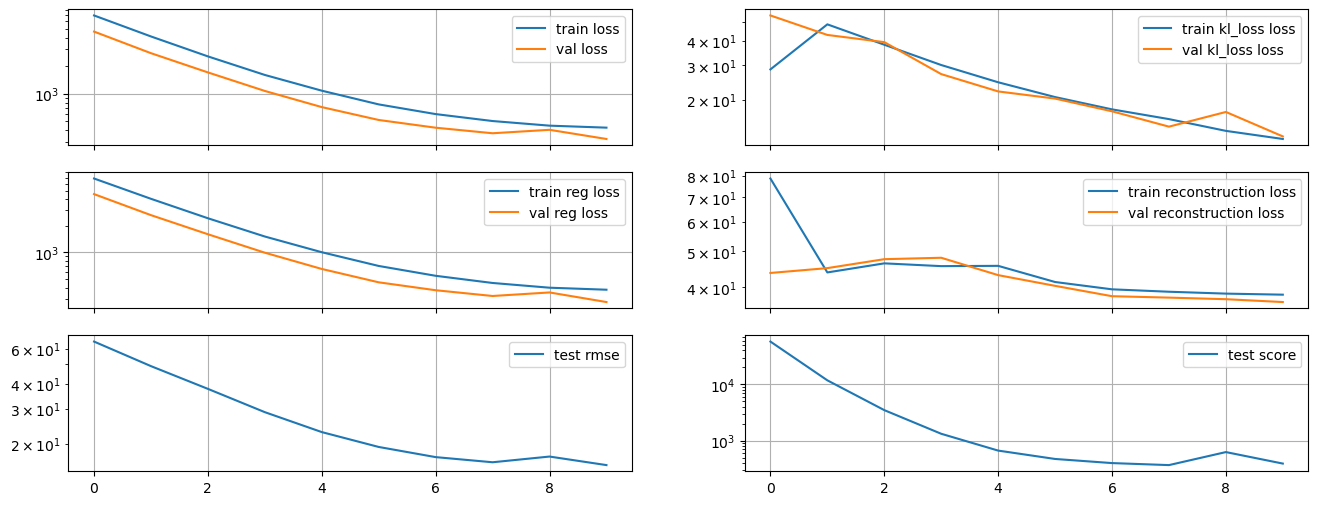

Epoch:10 
Train loss: 428.97 kl loss: 12.57 reg loss: 378.22 recon loss: 38.19
Valid loss: 323.83 kl loss: 12.95 reg loss: 274.4 recon loss: 36.48
Test:
     RMSE: 15.66      Score: 391.66
Best RMSE: 15.66 Best Score: 368.03


In [126]:
trainer.train(10)

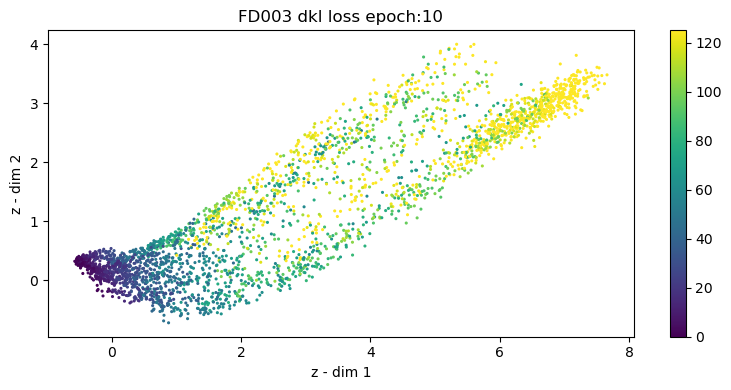

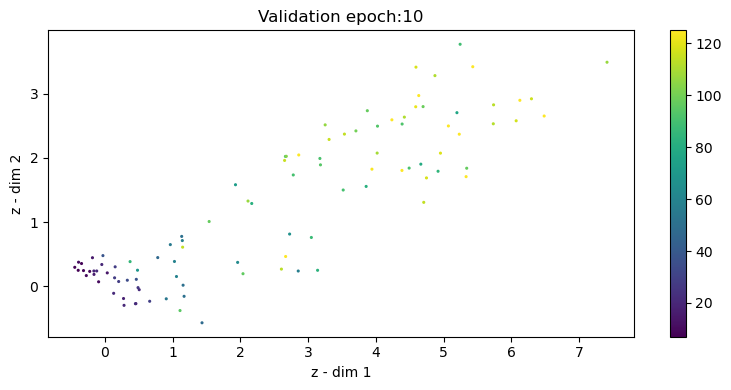

In [127]:
epoch = trainer.epochs
model = trainer.model

#viz_latent_space(model, x_train[::3], y_train[::3], title=f'Train epoch:{epoch}')
viz_latent_space(model, x_val, y_val, title=f'FD003 dkl loss epoch:{epoch}', save=True)
viz_latent_space(model, x_test, y_test, title=f'Validation epoch:{epoch}')
model.train().to('cuda');

In [128]:
PATH = './saved_models/FD004_dkl_recon_reg.pt'
torch.save(model, PATH)

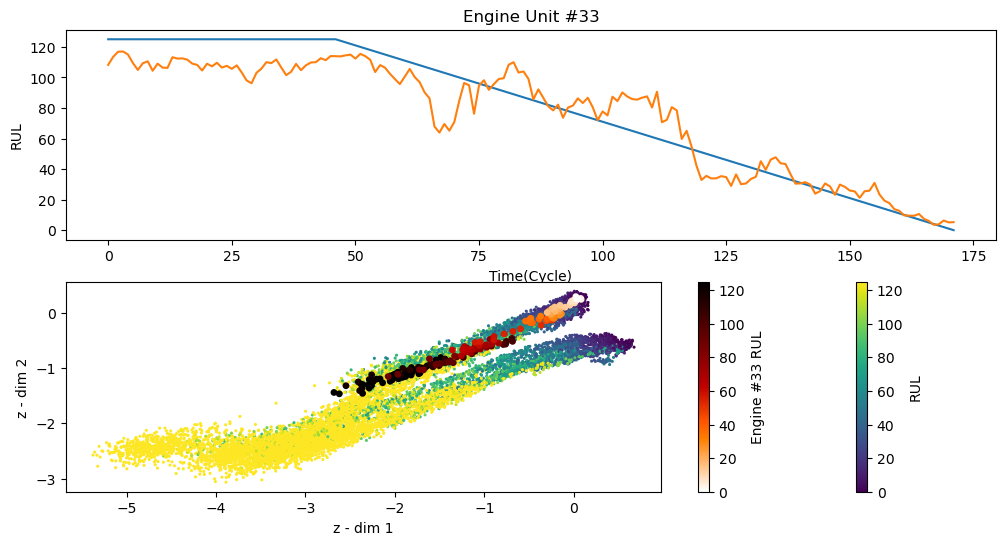

In [61]:
history = get_engine_runs(val_loader, model)
plot_engine_run(history, 33, save=True, title="FD004_all_losses")

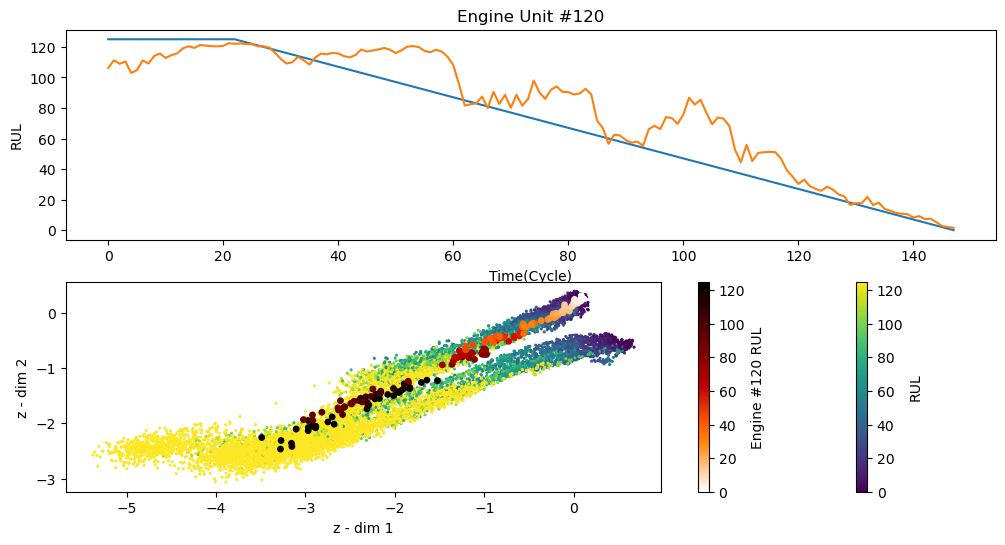

In [66]:
plot_engine_run(history, save=True, title="FD004_all_losses")

In [90]:
from rve_utils import get_trainer, get_engine_runs, plot_engine_run
from collections import defaultdict
import torch
import random
import matplotlib.pyplot as plt

sensors = ['s_3', 's_4', 's_7', 's_11', 's_12'] #FD001 FD003

input_size = len(sensors)
hidden_dim = 100

model = SimpleRVE(input_size, hidden_dim, dropout=0.5, bidirectional=True)

trainer, x_train, y_train, x_val, y_val, x_test, y_test, train_loader, test_loader, val_loader = get_trainer("FD001", sensors, reconstruct=False, model=model, lr=0.001)

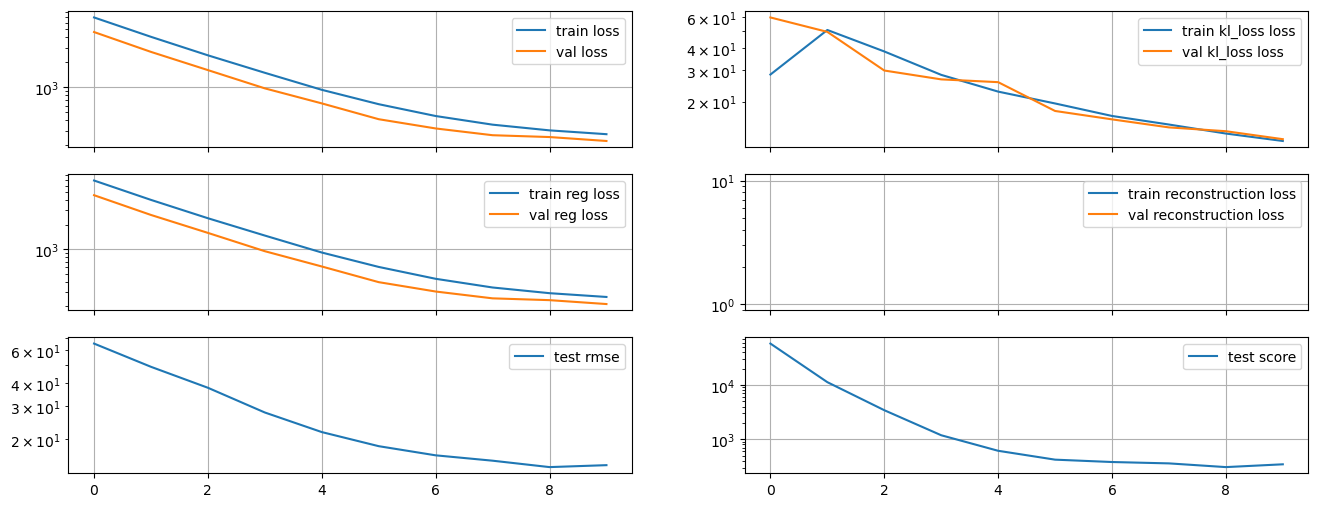

Epoch:10 
Train loss: 271.56 kl loss: 12.01 reg loss: 259.54 recon loss: 0.0
Valid loss: 224.88 kl loss: 12.3 reg loss: 212.58 recon loss: 0.0
Test:
     RMSE: 14.5      Score: 345.23
Best RMSE: 14.16 Best score: 306.67


In [91]:
trainer.train(10)

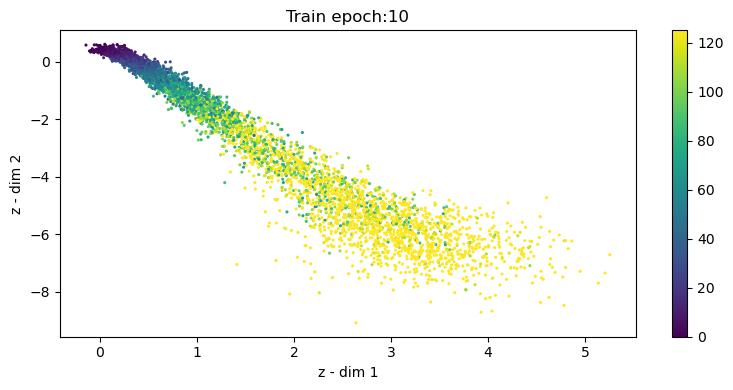

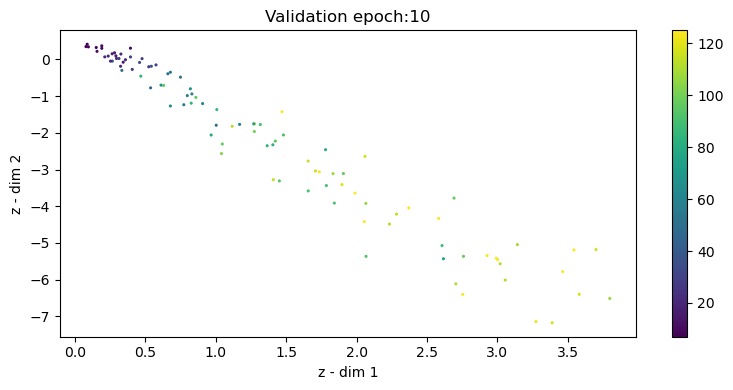

In [92]:
epoch = trainer.epochs
model = trainer.model

viz_latent_space(model, x_train[::3], y_train[::3], title=f'Train epoch:{epoch}')
#viz_latent_space(model, x_val, y_val, title=f'Test epoch:{epoch}')
viz_latent_space(model, x_test, y_test, title=f'Validation epoch:{epoch}')
model.train().to('cuda');

In [50]:
sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD002

input_size = len(sensors)
hidden_dim = 300

model = SimpleRVE(input_size, hidden_dim, dropout=0.0)

trainer, x_train, y_train, x_val, y_val, x_test, y_test, train_loader, test_loader, val_loader = get_trainer("FD002", sensors, reconstruct=False, model=model, lr=0.001)

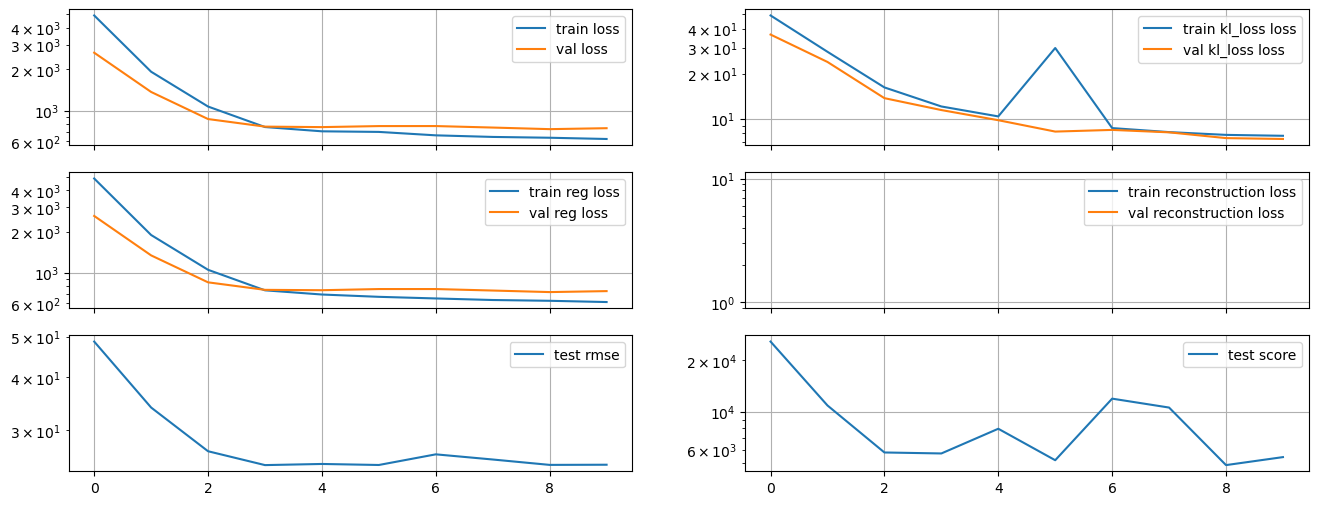

Epoch:10 
Train loss: 621.9 kl loss: 7.72 reg loss: 614.18 recon loss: 0.0
Valid loss: 744.86 kl loss: 7.35 reg loss: 737.51 recon loss: 0.0
Test:
     RMSE: 24.84      Score: 5430.12
Best RMSE: 24.79 Best score: 4876.91


In [51]:
trainer.train(10)

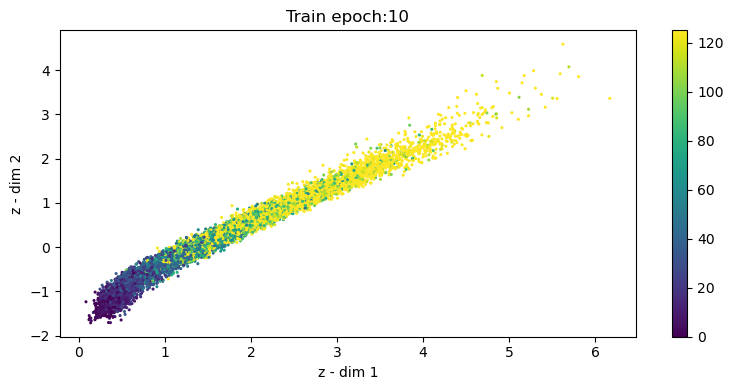

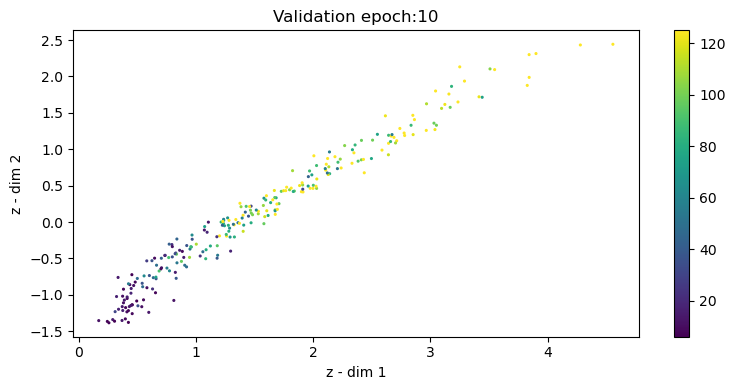

In [52]:
epoch = trainer.epochs
model = trainer.model

viz_latent_space(model, x_train[::3], y_train[::3], title=f'Train epoch:{epoch}')
#viz_latent_space(model, x_val, y_val, title=f'Test epoch:{epoch}')
viz_latent_space(model, x_test, y_test, title=f'Validation epoch:{epoch}')
model.train().to('cuda');

In [47]:
sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD004
input_size = len(sensors)
hidden_dim = 300

model = SimpleRVE(input_size, hidden_dim, dropout=0.0, bidirectional=True)

trainer, x_train, y_train, x_val, y_val, x_test, y_test, train_loader, test_loader, val_loader = get_trainer("FD004", sensors, reconstruct=False, model=model, lr=0.001)

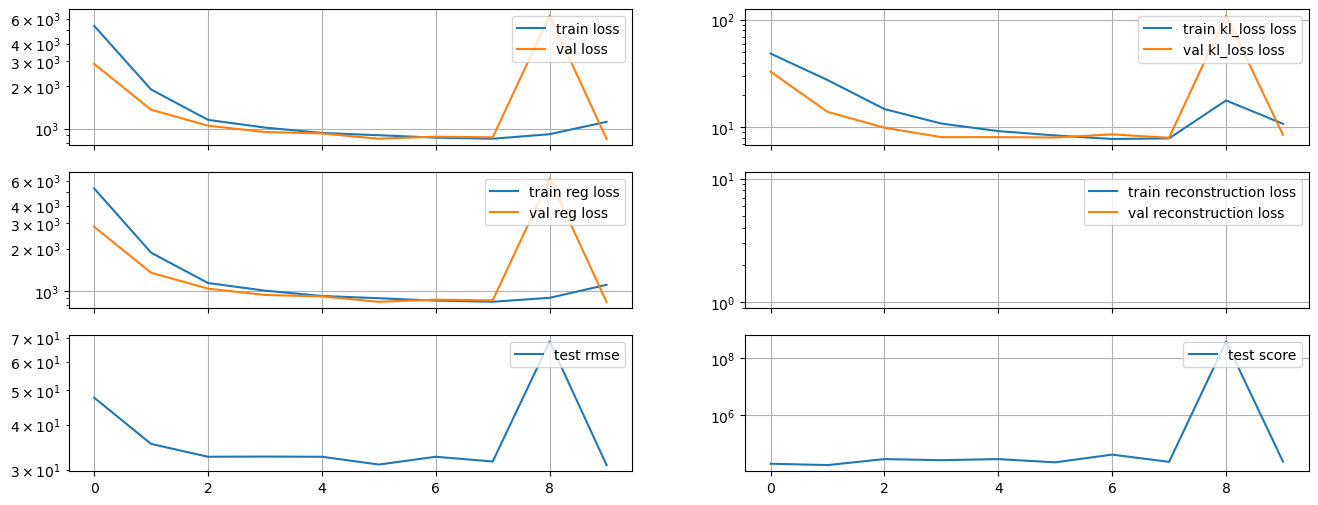

Epoch:10 
Train loss: 1121.6 kl loss: 10.79 reg loss: 1110.81 recon loss: 0.0
Valid loss: 848.77 kl loss: 8.52 reg loss: 840.25 recon loss: 0.0
Test:
     RMSE: 30.9      Score: 23575.23
Best RMSE: 30.9 Best score: 17697.15


In [48]:
trainer.train(10)

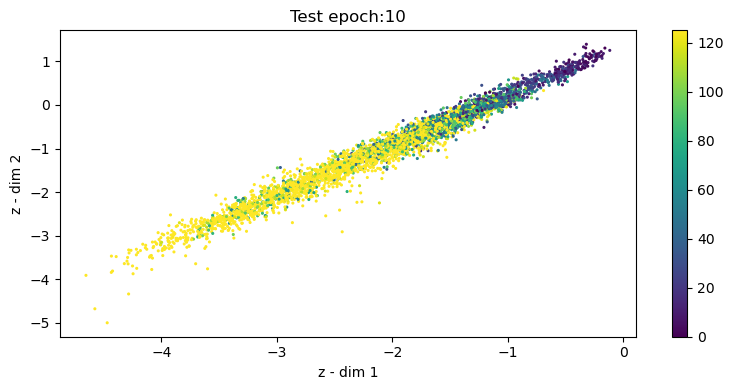

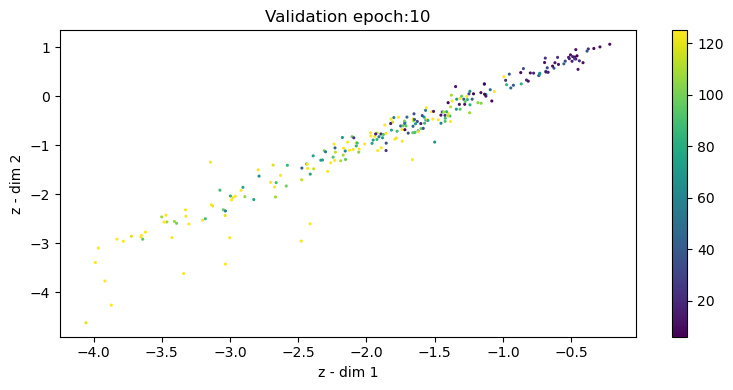

In [49]:
epoch = trainer.epochs
model = trainer.model

#viz_latent_space(model, x_train[::3], y_train[::3], title=f'Train epoch:{epoch}')
viz_latent_space(model, x_val[::3], y_val[::3], title=f'Test epoch:{epoch}')
viz_latent_space(model, x_test, y_test, title=f'Validation epoch:{epoch}')
model.train().to('cuda');